# non-negative matrix factorization

In [8]:
# nonnegative matrix factorization
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [11]:
def nmf_basic(V, rank, max_iter=100, tol=1e-4):
    """
    Basic NMF implementation using multiplicative update rules.
    
    Parameters:
        V (ndarray): Input nonnegative matrix (m x n).
        rank (int): Rank of the decomposition.
        max_iter (int): Maximum number of iterations.
        tol (float): Tolerance for convergence.
    
    Returns:
        W (ndarray): Basis matrix (m x rank).
        H (ndarray): Coefficient matrix (rank x n).
    """
    m, n = V.shape
    
    # Initialize W and H with random nonnegative values
    W = np.random.rand(m, rank)
    H = np.random.rand(rank, n)
    
    for i in range(max_iter):
        # Update rules
        H = H * (W.T @ V) / (W.T @ W @ H + 1e-10)
        W = W * (V @ H.T) / (W @ (H @ H.T) + 1e-10)
        
        # Check convergence
        reconstruction = W @ H
        error = np.linalg.norm(V - reconstruction, ord='fro')
        if error < tol:
            break
    
    return W, H

def nmf_with_constraints(V, rank, max_iter=100, tol=1e-4, alpha=0.1, beta=0.1):
    """
    Constrained NMF implementation with sparsity penalties.
    
    Parameters:
        V (ndarray): Input nonnegative matrix (m x n).
        rank (int): Rank of the decomposition.
        max_iter (int): Maximum number of iterations.
        tol (float): Tolerance for convergence.
        alpha (float): Sparsity penalty for W.
        beta (float): Sparsity penalty for H.
    
    Returns:
        W (ndarray): Basis matrix (m x rank).
        H (ndarray): Coefficient matrix (rank x n).
    """
    m, n = V.shape
    
    # Initialize W and H
    W = np.random.rand(m, rank)
    H = np.random.rand(rank, n)
    
    for i in range(max_iter):
        # Update rules with sparsity
        H = H * (W.T @ V) / (W.T @ W @ H + beta + 1e-10)
        W = W * (V @ H.T) / (W @ (H @ H.T) + alpha + 1e-10)
        
        # Check convergence
        reconstruction = W @ H
        error = np.linalg.norm(V - reconstruction, ord='fro')
        if error < tol:
            break
    
    return W, H

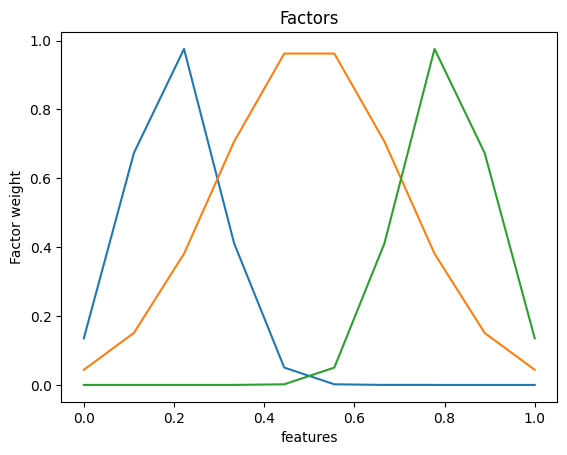

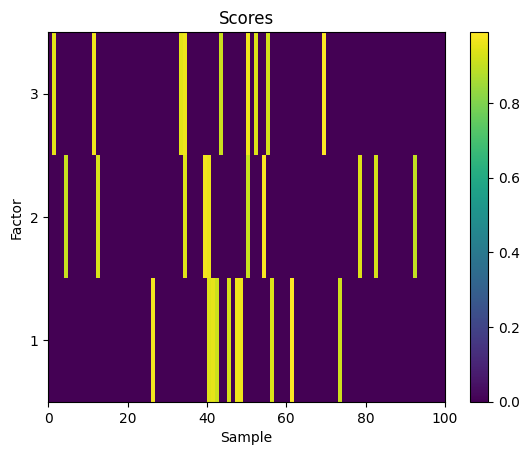

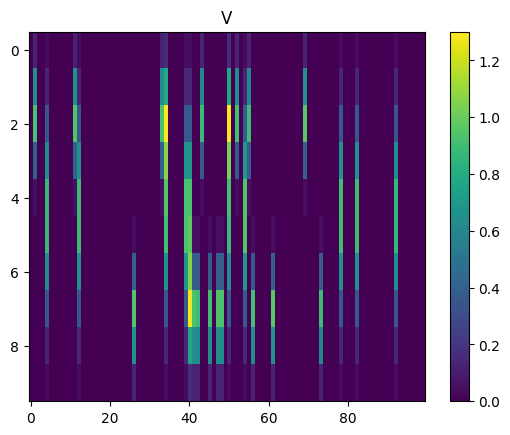

In [42]:
# Synthetic dataset
np.random.seed(42)

nfac = 3
nsamples = 100
ndim = 10

# gaussian bump 
def gaussian_bump(x, c, sigma):
    return np.exp(-np.square(x - c) / (2 * sigma**2))

x = np.linspace(0, 1, ndim)
factors_c = [0.2, 0.5, 0.8]
factors_sigma = [0.1, 0.2, 0.1]
factors = np.zeros((ndim, nfac))
for i in range(nfac):
    factors[:, i] = gaussian_bump(x, factors_c[i], factors_sigma[i])

scores = np.random.rand(nfac, nsamples)
scores[np.where(scores < 0.9)] = 0 # sparsity constraint

# factors is a matrix of shape (ndim, nfac)
# scores is a matrix of shape (nfac, nsamples)

V = factors @ scores
# V is a matrix of shape (ndim, nsamples)

# plot factors
plt.figure()
plt.plot(x, factors)
plt.xlabel('features')
plt.ylabel('Factor weight')
plt.title('Factors')

# plot scores
plt.figure()
plt.imshow(scores, aspect='auto', extent=[0, nsamples, 0, nfac])
plt.xlabel('Sample')
plt.ylabel('Factor')
# factor number as yticks
plt.yticks(np.arange(nfac)+0.5, np.arange(1, nfac+1))
plt.colorbar()
plt.title('Scores')
plt.show()

# plot V
plt.figure()
plt.imshow(V, aspect='auto')
plt.colorbar()
plt.title('V')
plt.show()

In [45]:
# Basic NMF
W_basic, H_basic = nmf_basic(V, rank=3)

# Constrained NMF
W_constrained, H_constrained = nmf_with_constraints(V, rank=3, alpha=0.1, beta=0.1)

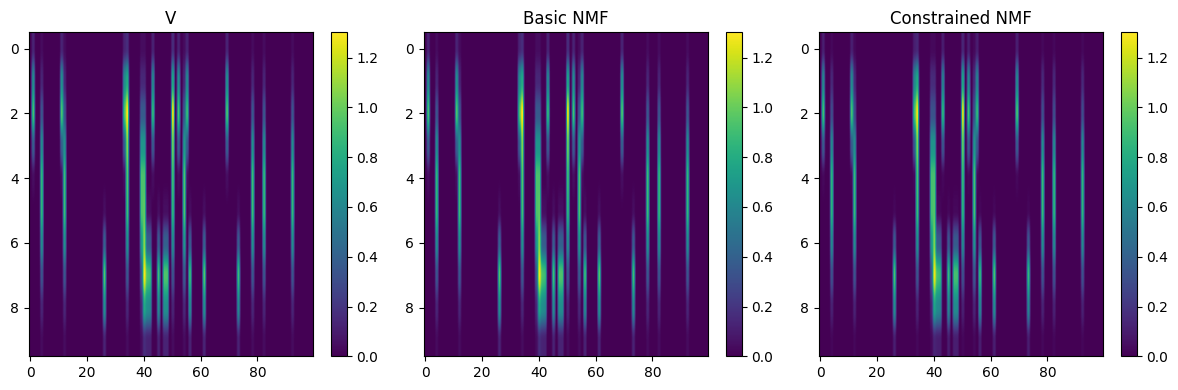

In [50]:
# plot result
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

vmin = min(V.min(), (W_basic @ H_basic).min(), (W_constrained @ H_constrained).min())
vmax = max(V.max(), (W_basic @ H_basic).max(), (W_constrained @ H_constrained).max())

im = axs[0].imshow(V, aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title('V')
fig.colorbar(im, ax=axs[0])

im = axs[1].imshow(W_basic @ H_basic, aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title('Basic NMF')
fig.colorbar(im, ax=axs[1])

im = axs[2].imshow(W_constrained @ H_constrained, aspect='auto', vmin=vmin, vmax=vmax)
axs[2].set_title('Constrained NMF')
fig.colorbar(im, ax=axs[2])

plt.tight_layout()
plt.show()

In [52]:
# reorder factors to match the original factors
def reorder_factors(W, H, factors):
    nfac = factors.shape[1]
    corr = np.zeros((nfac, nfac))
    for i in range(nfac):
        for j in range(nfac):
            corr[i, j] = np.corrcoef(W[:, i], factors[:, j])[0, 1]
    max_corr = np.argmax(corr, axis=1)
    W_reorder = W[:, max_corr]
    H_reorder = H[max_corr, :]
    return W_reorder, H_reorder

W_basic_reorder, H_basic_reorder = reorder_factors(W_basic, H_basic, factors)
W_constrained_reorder, H_constrained_reorder = reorder_factors(W_constrained, H_constrained, factors)

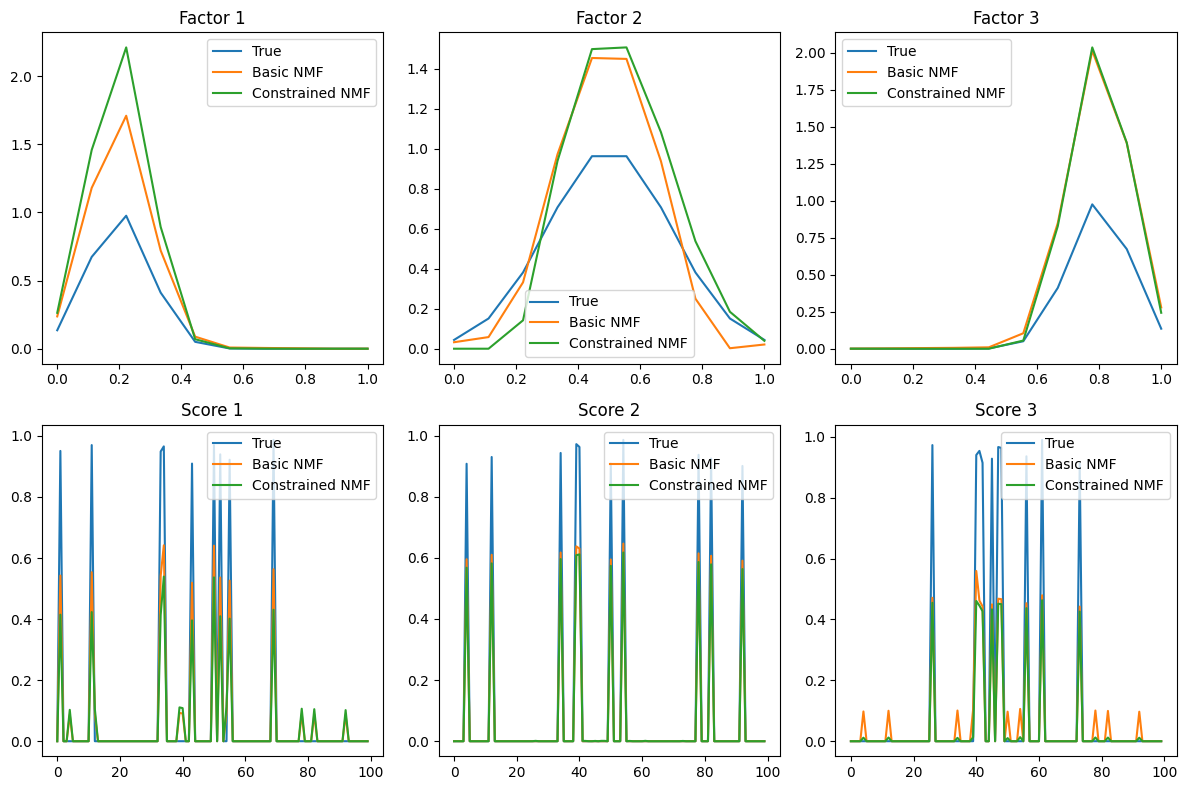

In [53]:
# plot W and H with reordered factors
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i in range(3):
    axs[0, i].plot(x, factors[:, i], label='True')
    axs[0, i].plot(x, W_basic_reorder[:, i], label='Basic NMF')
    axs[0, i].plot(x, W_constrained_reorder[:, i], label='Constrained NMF')
    axs[0, i].set_title(f'Factor {i+1}')
    axs[0, i].legend()

for i in range(3):
    axs[1, i].plot(scores[i, :], label='True')
    axs[1, i].plot(H_basic_reorder[i, :], label='Basic NMF')
    axs[1, i].plot(H_constrained_reorder[i, :], label='Constrained NMF')
    axs[1, i].set_title(f'Score {i+1}')
    axs[1, i].legend()

plt.tight_layout()
plt.show()

# Calcium Imaging Data

In [1]:
data_path = '/home/arash/Documents/Science/Uni/NeuroPy/NeuroPySeminar/data/Ms4-fc12.mat'

import numpy as np
import h5py as h5
file = h5.File(data_path, 'r')

# <KeysViewHDF5 ['data', 'scoringindex_file', 'xform_mask']>
data = file['data']
sleep_score = file['scoringindex_file']

# convert to numpy array
data = np.array(data)
sleep_score

<HDF5 dataset "scoringindex_file": shape (21, 1), type "<f8">

In [2]:
# convert to numpy array
sleep_score = np.array(sleep_score)

In [3]:
data.shape
nepochs = data.shape[0]
nsamples = data.shape[1]
nrows = data.shape[2]
ncols = data.shape[3]

In [4]:
sleep_score = np.squeeze(sleep_score)

# 3. Three variables in MsX/MsX_fcX.mat:
# (a) data: GCAMP recordings containing consecutive 10s epochs of size [128, 128, 168, #epochs], each 10s epoch has 168 frames.
# (b) scoringindex_file: 1D scoring vectors, 0=wake, 1=NREM, 2=Artifacts, 3=REM
# (c) xform_mask: brain mask defining the brain tissue within FOV

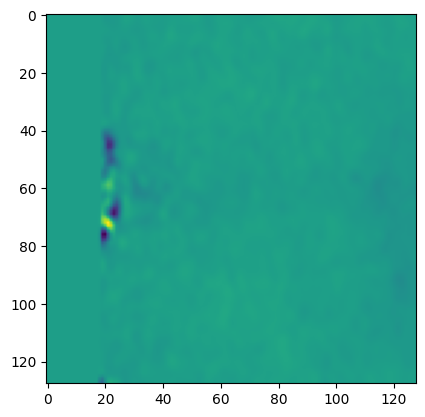

In [5]:
import matplotlib.pyplot as plt

plt.imshow(data[0, 2])

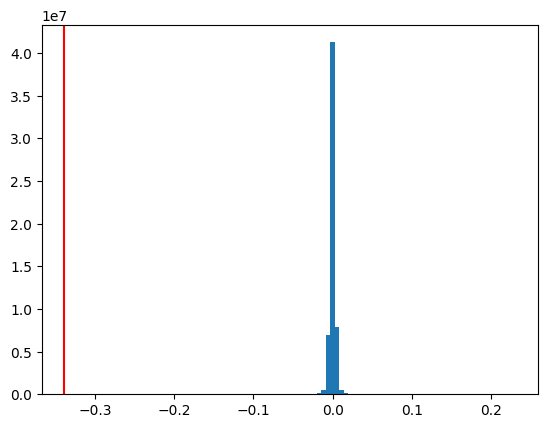

In [61]:
min_data = data.min()
plt.hist(data.reshape(-1), bins=100)
# vertical line at min_data
plt.axvline(min_data, color='r')
plt.show()

In [67]:
# subtract minimum value from data to make it nonnegative
datan = data - min_data + 0.01

In [68]:
np.all(datan > 0)

np.True_

# Design matrix


In [69]:
datan.shape

(21, 168, 128, 128)

In [70]:
# downsample data (lower spatial resolution)

# apply median filter to remove noise
from scipy.ndimage import gaussian_filter

gdata = gaussian_filter(datan, sigma=(3, 3), axes=(2, 3))

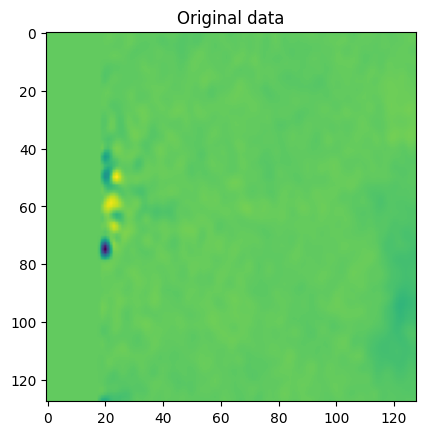

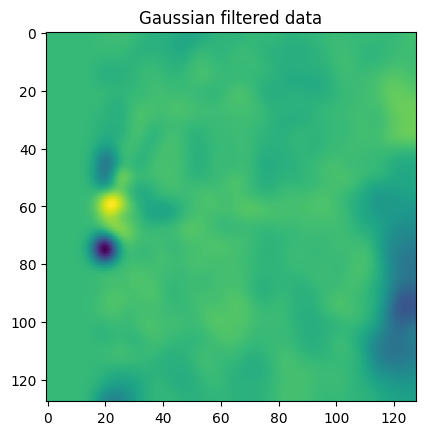

In [71]:
plt.figure()
plt.imshow(datan[0, 1])
plt.title('Original data')

plt.figure()
plt.imshow(gdata[0, 1])
plt.title('Gaussian filtered data')
plt.show()


Text(0.5, 1.0, 'Downsampled data')

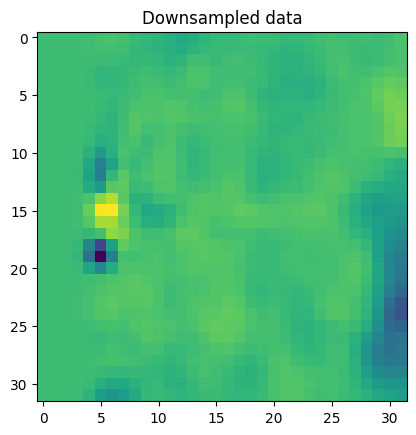

In [72]:
# downsample

data_ds = gdata[:, :, ::4, ::4]
plt.figure()
plt.imshow(data_ds[0, 1])
plt.title('Downsampled data')

In [73]:
# datan.shape  (21, 168, 128, 128)
data_flat = np.reshape(data_ds, (nepochs, nsamples, -1))
data_flat.shape

(21, 168, 1024)

In [74]:
# divide into brain states from sleep score
wake = data_flat[sleep_score == 0]
nrem = data_flat[sleep_score == 1]
artifacts = data_flat[sleep_score == 2]
rem = data_flat[sleep_score == 3]


In [75]:
wake_concat = np.concatenate(wake)
nrem_concat = np.concatenate(nrem)

# ROI

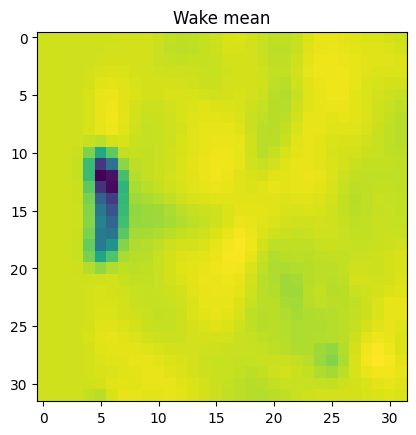

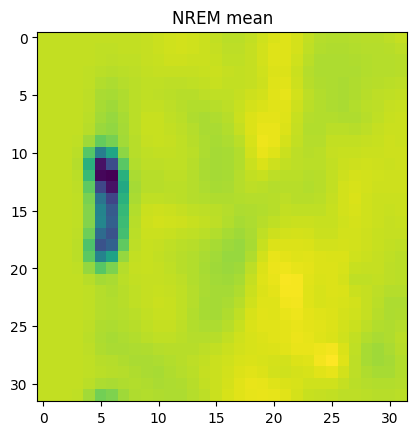

In [31]:
# mean of wake and nrem
wake_mean = np.mean(wake_concat, axis=0)
nrem_mean = np.mean(nrem_concat, axis=0)

plt.figure()
plt.imshow(wake_mean.reshape(32, 32))
plt.title('Wake mean')

plt.figure()
plt.imshow(nrem_mean.reshape(32, 32))
plt.title('NREM mean')
plt.show()

/tmp/ipykernel_157158/1421987023.py:11: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(nrem_var).reshape(32, 32))


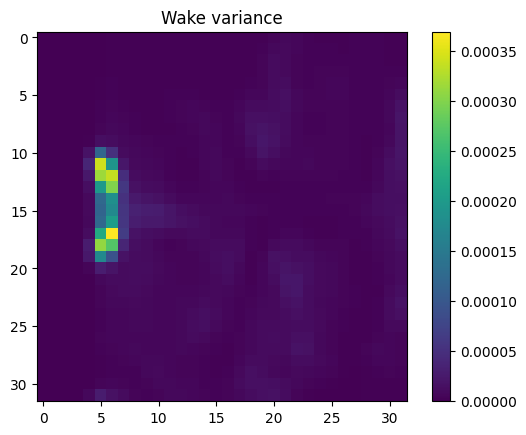

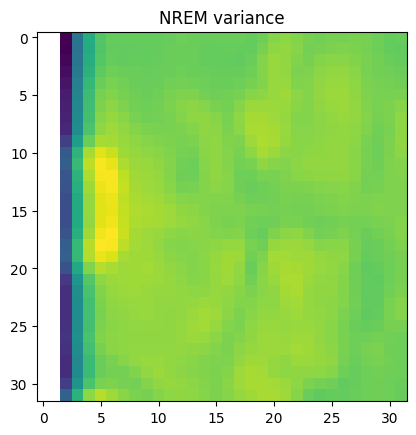

In [46]:
# variance of wake and nrem
wake_var = np.var(wake_concat, axis=0)
nrem_var = np.var(nrem_concat, axis=0)

plt.figure()
plt.imshow(wake_var.reshape(32, 32))
plt.colorbar()
plt.title('Wake variance')

plt.figure()
plt.imshow(np.log(nrem_var).reshape(32, 32))
plt.title('NREM variance')
plt.show()

In [37]:
# restrain to ROI
waken = datan[sleep_score == 0]
nremn = datan[sleep_score == 1]

# concatenate
waken_concat = np.concatenate(waken)
nremn_concat = np.concatenate(nremn)

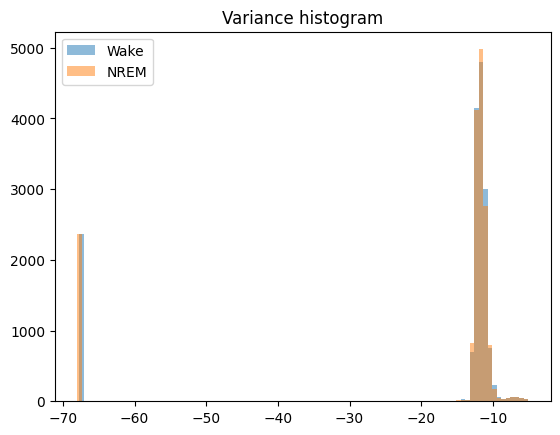

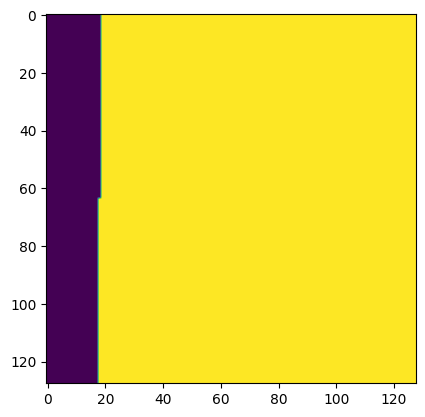

In [45]:
# compute variance 
wake_varn = np.var(waken_concat, axis=0)
nrem_varn = np.var(nremn_concat, axis=0)

# plot histogram of variance
plt.figure()
plt.hist(np.log(wake_varn).reshape(-1), bins=100, alpha=0.5, label='Wake')
plt.hist(np.log(nrem_varn).reshape(-1), bins=100, alpha=0.5, label='NREM')
plt.legend()
plt.title('Variance histogram')
plt.show()

# threshold by eye -20
threshold = np.exp(-20)

# apply threshold
plt.imshow(wake_varn > threshold)

# Without ROI

In [76]:
wake_concat.shape
nrem_concat.shape

(1848, 1024)

In [86]:
from sklearn.decomposition import NMF

nmf_wake = NMF(n_components=10, max_iter=1000)
W_wake = nmf_wake.fit_transform(wake_concat)
H_wake = nmf_wake.components_

nmf_nrem = NMF(n_components=10, max_iter=1000)
W_nrem = nmf_nrem.fit_transform(nrem_concat)
H_nrem = nmf_nrem.components_

In [92]:
H_wake_reshape = H_wake.reshape(10, 32, 32)
H_nrem_reshape = H_nrem.reshape(10, 32, 32)

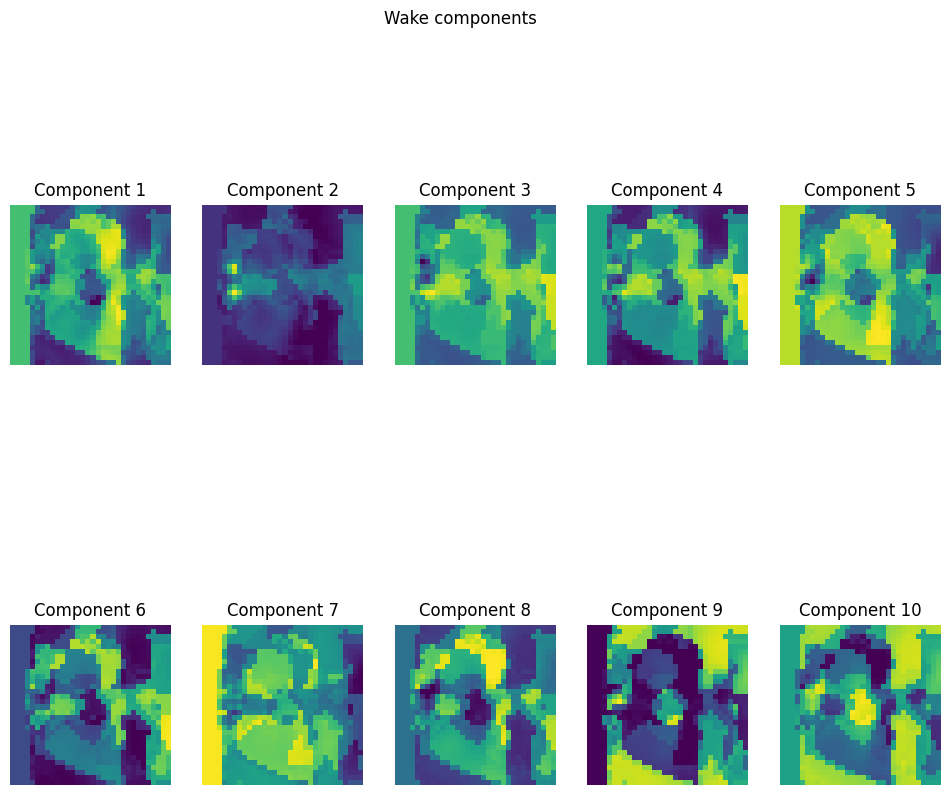

In [95]:
# plot 4 x 5 components
fig, axs = plt.subplots(2, 5, figsize=(12, 10))

for i in range(2):
    for j in range(5):
        axs[i, j].imshow(H_wake_reshape[i*5+j])
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Component {i*5+j+1}')
    
plt.suptitle('Wake components')
plt.show()

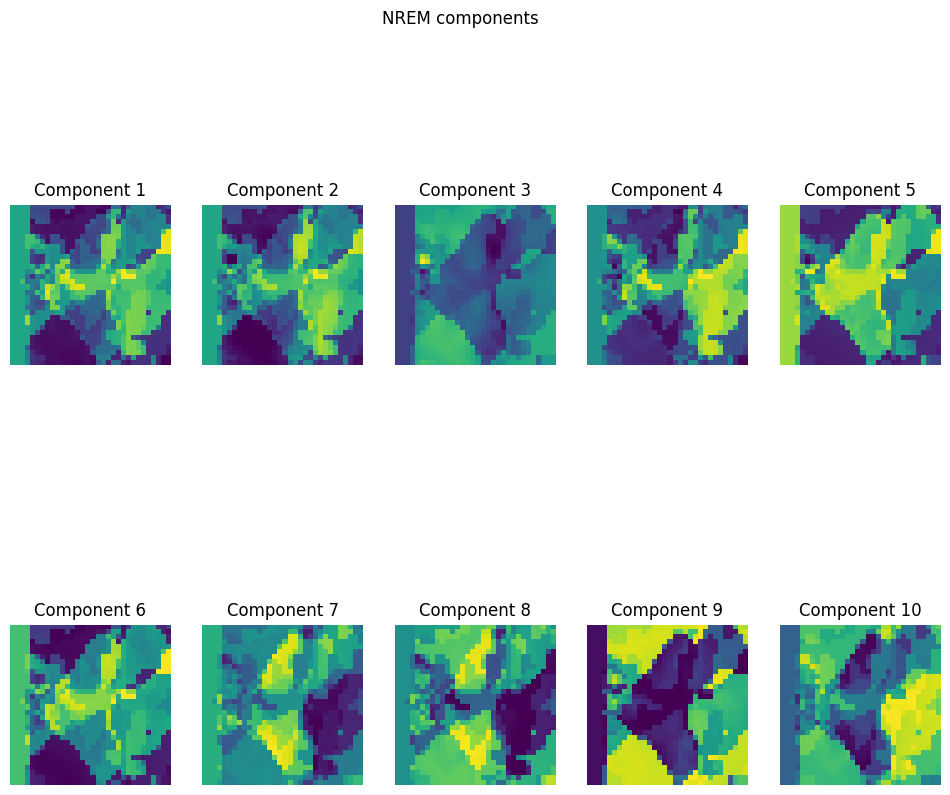

In [96]:
# plot 4 x 5 components
fig, axs = plt.subplots(2, 5, figsize=(12, 10))

for i in range(2):
    for j in range(5):
        axs[i, j].imshow(H_nrem_reshape[i*5+j])
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Component {i*5+j+1}')
    
plt.suptitle('NREM components')
plt.show()